# Refrigeration System Analysis

This  analyis estimates the fuel savings that could be achieved by upgrading the refrigeration system on board F/V Eigil B. The calculation has three parts: first, parameters of the refrigeration systems are determined. Second, the fuel consumption rate of the generators is calculated as a function of load. Finally, the annual fuel consumption due to refrigeration is calculated based on the generator fuel consumption curves and the refrigeration load.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import copy
%matplotlib inline
water_heat_cap = 8.35 # btu/gal-F
joule_per_btu = 1055 
sec_per_hr = 3600
watt_per_kW = 1000

## Freezer load

### New Bitzer system
Compressor data from Bitzer Software v6.6.0 Open Drive Recips. Model 6F.2-K, Condensing SDT 86 deg F. Liq subc 15 deg F, Suction gas superheat 15 deg F. Motor speed 1750/min, coupling 1:1. The parameter min_power is the power required to run the compressor at the minimum speed (900 r/min) at the minimum sst (24 deg F).

In [4]:
sst = np.array([42, 40, 38, 36, 34, 32, 30, 28, 26, 24]) #deg F
n_comp = 2
delta_sst = sst[0]-sst[1]
comp_capacity = np.array([463, 442, 422, 403, 385, 367, 349, 333, 317, 301])*1e3*n_comp 
    #btu/hr
comp_power = np.array([22.3, 21.9, 21.6, 21.3, 20.9, 20.6, 20.2, 19.9, 19.57, 19.24])*n_comp 
    # kW

In [5]:
sea_temp = 59
target_temp = 33
aft_tank_capacity = 19448 # gallons
forward_tank_capacity = 14960 # gallons
n_aft_tank_pulldown = 33 # pulldowns per year
n_all_tank_pulldown = 1 # pulldowns per year
lbs_fish_cooled = 1.588e6
hrs_holding_aft_temp = 48.3
hrs_holding_all_temp = 0 # Herring season only--no data available
circ_pump_cap = 7.5 * 0.746 # kW
n_circ_pump = 2
condenser_pump_cap = 3 * 0.746 # kW
compressor_cool_pump = 2 * 0.746 # kW
hrs_filling_tanks = (64/60 * n_aft_tank_pulldown + 1.9 * n_all_tank_pulldown)*2
min_power = 9.51 # kW

### Old system

In [6]:
motor_power = 40 * 0.746 # kW
total_time = 504.2 #hrs

## Auxiliary Generator BSFC
The fuel consumption as a function of load is calculated based on manufacturer's data: Engine Performance Curve John Deere  4045TFM75. John Deere. 2007.  http://silniki.info.pl/upload/pdf/karta%20produktu%204045TFM75%2055%20kW%20@1500%20&%201800.pdf The figure shows that a linear equation fits the data well. The fit shown in the figure below is used in the remainder of the report to estimate fuel consumption.

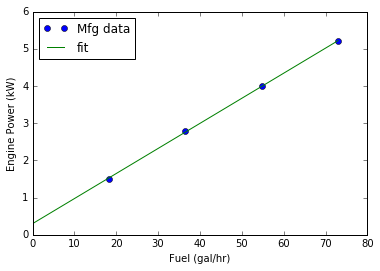

In [7]:
Aux1 = {}
Aux1['Capacity_kW'] = 65
Aux1['Fuel_gal_hr'] = np.array([1.5, 2.8, 4.0, 5.2])
# Note: According to the doc, the engine is rated to 73 kW, although the generator on
# board is rated to 65 kW. The 73 kW engine rating is used here. The generator load 
# should be divided by an efficiency of 65/73 to get the engine load.
ratedpower = 73 # kW
Aux1['gen_eff'] = 65/73
Aux1['Power_kW'] = ratedpower * np.array([0.25, 0.5, 0.75, 1.0])
Aux1['bsfc_coeffs'] = np.polyfit(Aux1['Power_kW'], Aux1['Fuel_gal_hr'], 1)
powertest = np.linspace(0, ratedpower, 100)
fueltest = Aux1['bsfc_coeffs'][0]*powertest + Aux1['bsfc_coeffs'][1]
plt.plot(Aux1['Power_kW'], Aux1['Fuel_gal_hr'], 'o', label='Mfg data')
plt.plot(powertest, fueltest, label='fit')
plt.xlabel('Fuel (gal/hr)')
plt.ylabel('Engine Power (kW)')
plt.legend(loc='best')

The second auxiliary generator has the same engine (John Deere 4045TFM75), but the generator is rated to 100 kW rather than 65 kW. Data sheets for the 4045TFM75 reveals that the engine is rated to 80 kW under M1 conditions (operating over 3000 hours per year and load factors over 65%) and to 101 kW under M3 conditions (up to 2000 hours per year, and load factors under 50%). Since the both auxiliary generators use the same engine, the same fuel consumption curve is used for each.

In [9]:
Aux2 = copy.copy(Aux1)
Aux2['Capacity_kW'] = 100

## Fuel consumption calculation
There are three modes considered here:
1.) Filling the tanks with water
2.) Pulling the hold down to temperature
3.) Maintaining hold temperature

### Filling tanks

In [10]:
load_kw = n_circ_pump * circ_pump_cap / Aux1['gen_eff']
fuel_a = Aux1['bsfc_coeffs'][0]
fuel_b = Aux1['bsfc_coeffs'][1]
filling_fuel = (fuel_a*load_kw + fuel_b) * hrs_filling_tanks
print(filling_fuel)

85.1071716923


### Pulling down hold

#### Salmon season: Aft holds only

In [14]:
btus_removed = aft_tank_capacity * water_heat_cap * (sea_temp - target_temp)
btu_per_sst = btus_removed/(delta_sst*len(sst))
heat_load = circ_pump_cap / joule_per_btu * watt_per_kW * sec_per_hr # btu/hr
extra_loads = circ_pump_cap * n_circ_pump + condenser_pump_cap + compressor_cool_pump
# Note: comp_capacity is an array with many entries. The operation below 
# defines "times" as an array with the same dimension.
times = btu_per_sst * delta_sst / (comp_capacity - heat_load)
salmon_pumpdown_fuel = sum((fuel_a * (comp_power+extra_loads)/Aux1['gen_eff'] + 
                            fuel_b)*times) * n_aft_tank_pulldown
print(salmon_pumpdown_fuel)

876.957488662


#### Herring season: all holds

In [15]:
tank_cap = aft_tank_capacity + forward_tank_capacity
btus_removed = tank_cap * water_heat_cap * (sea_temp - target_temp)
btu_per_sst = btus_removed/(delta_sst*len(sst))
heat_load = circ_pump_cap / joule_per_btu * watt_per_kW * sec_per_hr # btu/hr
# times (hrs) is an array with of dimension comp_capacity.shape
times = btu_per_sst * delta_sst / (comp_capacity - heat_load)
herring_pumpdown_fuel = sum((fuel_a * (comp_power + extra_loads)/Aux1['gen_eff'] + 
                             fuel_b)*times) * n_all_tank_pulldown
print(herring_pumpdown_fuel)

47.016368856


### Maintaining temp

There are two subsections here: cooling off fish, and maintaining the hold independently of the fish. The fuel used to cool fish is calculated by assuming that the compressor is operating at conditions when the hold is cold-an SST of 24 degrees. The time to pump out the btus in the fish is calculated at that condition (assuming that the fish have the same heat capacity as water on a mass basis). This time is then subtracted from the total freezer run time to get the time required to simply maintain temperature.

The temperature maintenance fuel demand is calculated by assuming that the compressor will run continuously at its minimum speed. The compressor power is then used to calculate the fuel consumption rate.

In [16]:
fish_hours = lbs_fish_cooled * (sea_temp-target_temp) * 1 / (comp_capacity[-1]-heat_load)
fish_cooling_fuel = fish_hours * (fuel_a * (comp_power[-1] + extra_loads) / 
                                  Aux1['gen_eff'] + fuel_b)
print(fish_cooling_fuel)

307.546316244


In [17]:
fish_hours

70.831067632787395

In [18]:
total_fuel = fish_cooling_fuel + herring_pumpdown_fuel + salmon_pumpdown_fuel + filling_fuel
print(total_fuel)

1316.62734545


## Old system estimate

I haven't been able to find data relating sst to compressor capacity for the old system. To get a rough estimate, I simply assume that the compressor motor runs at its rated power all the time.

In [19]:
old_comp_total_kw = (motor_power + circ_pump_cap * n_circ_pump + condenser_pump_cap + 
                     compressor_cool_pump)/Aux1['gen_eff']
old_total_fuel = total_time * (fuel_a * old_comp_total_kw + fuel_b) + filling_fuel
print(old_total_fuel)

1944.59056615


## Summary

The old system was estimated at 1944 gal/yr, while the new system was estimated at 1317 gal/yr. However, there are numerous problems with these estimates:

1.) The compressor motor does not run at rated power all the time in the old system, but that is how it was modeled in the above calculations. The motor is likely oversized and never actually reaches full power. Once the hold is cold, the compressor probably cycles on and off with some unknown duty cycle (although this won't have much effect on the results, since so little time is allocated to maintaining temperature).

2.) The heating load only accounts for heat from the circ pumps; not heat infiltration through the hold insulation was included.

3.) With the new system, 70 hours were allocated to cooling fish. This is more than the total recorded hold maintenance time. It may be that the vessel off loads fish before they reach 33 deg F (assuming that the reported transit/maintenance time is correct).

4.) All estimates are based on name plate data, with little to no allowance for inefficiencies.